<h2>Gett - Business Analysis - Insights from Failed Orders</h2>

<h4>Problem Statement:</h4>

Gett, previously known as GetTaxi, is an Israeli-developed technology platform solely focused on corporate Ground Transportation Management (GTM). They have an application where clients can order taxis, and drivers can accept their rides (offers). At the moment, when the client clicks the Order button in the application, the matching system searches for the most relevant drivers and offers them the order. In this task, we would like to investigate some matching metrics for orders that did not completed successfully, i.e., the customer didn't end up getting a car.

<h4>Assignment:</h4>

Please complete the following tasks.

 - Build up distribution of orders according to reasons for failure: cancellations before and after driver assignment, and reasons for order rejection. Analyse the resulting plot. Which category has the highest number of orders?
 - Plot the distribution of failed orders by hours. Is there a trend that certain hours have an abnormally high proportion of one category or another? What hours are the biggest fails? How can this be explained?
 - Plot the average time to cancellation with and without driver, by the hour. If there are any outliers in the data, it would be better to remove them. Can we draw any conclusions from this plot?
 - Plot the distribution of average ETA by hours. How can this plot be explained?
 - BONUS Hexagons. Using the h3 and folium packages, calculate how many sizes 8 hexes contain 80% of all orders from the original data sets and visualise the hexes, colouring them by the number of fails on the map.

<h4>Data Description:</h4>

We have two data sets: data_orders and data_offers, both being stored in a CSV format. The data_orders data set contains the following columns:

 - order_datetime - time of the order
 - origin_longitude - longitude of the order
 - origin_latitude - latitude of the order
 - m_order_eta - time before order arrival
 - order_gk - order number
 - order_status_key - status, an enumeration consisting of the following mapping:
    - 4 - cancelled by client,
    - 9 - cancelled by system, i.e., a reject
 - is_driver_assigned_key - whether a driver has been assigned
 - cancellation_time_in_seconds - how many seconds passed before cancellation
 - 
The data_offers data set is a simple map with 2 columns:

 - order_gk - order number, associated with the same column from the orders data set
 - offer_id - ID of an offer

In [34]:
# import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import h3
import folium

In [35]:
# read the csv dataset
orders = pd.read_csv("archive/data_orders.csv")
offers = pd.read_csv("archive/data_offers.csv")

In [36]:
# let's check some few records from datasets
orders.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN


In [37]:
offers.head()

,order_gk,offer_id
0,3000579625629,300050936206
1,3000627306450,300052064651
2,3000632920686,300052408812
3,3000632771725,300052393030
4,3000583467642,300051001196


In [38]:
print("Orders dataset:", orders.shape)
print("Offers dataset:", offers.shape)

Orders dataset: (10716, 8)
Offers dataset: (334363, 2)


In [39]:
# datatypes
print("Orders dataset:\n", orders.dtypes)
print()
print("Offers dataset:\n", offers.dtypes)

Orders dataset:
 order_datetime                    object
origin_longitude                 float64
origin_latitude                  float64
m_order_eta                      float64
order_gk                           int64
order_status_key                   int64
is_driver_assigned_key             int64
cancellations_time_in_seconds    float64
dtype: object

Offers dataset:
 order_gk    int64
offer_id    int64
dtype: object


In [40]:
# Data cleaning
orders['order_datetime'] = pd.to_datetime(orders['order_datetime'])
orders['hour'] = orders['order_datetime'].dt.hour

In [41]:
orders.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,hour
0,2024-05-23 18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0,18
1,2024-05-23 20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,20
2,2024-05-23 12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0,12
3,2024-05-23 13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0,13
4,2024-05-23 21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN,21


In [42]:
# check for null/duplicates
orders.isnull().sum()

order_datetime                      0
origin_longitude                    0
origin_latitude                     0
m_order_eta                      7902
order_gk                            0
order_status_key                    0
is_driver_assigned_key              0
cancellations_time_in_seconds    3409
hour                                0
dtype: int64

In [43]:
orders.duplicated().sum()

0

As you can see that there are no duplicate values present in our orders data. However, there are some missing values i.e NaN values present in features "m_order_eta" and "cancellations_time_in_seconds". Now, we can either impute them or just remove them or ignore while analyzing. Before we proceed with any of these methods, It is important to see the relationship of these features with the other to see if there is any pattern. Now, if it is showing any pattern or indicating a cause and effect relationship, we have to keep the values as it is and ignore them while data visualization to get more accurate analysis.

To perform this analysis we will first create two datasets: system_cancel and client_cancel which indicates the orders are cancelled by system and client repectively. Then, we will analyze the relationship between the features for both the data. Here, we have to analyze the relationship between "order_status_key" which represents whether the order is cancelled by system or client and the features "m_order_eta", "is_driver_assigned_key", "cancellations_time_in_seconds" to see if it indicates any pattern or provides insights on why there are NaN values present. 

In [44]:
# system cancel data
system_cancel = orders[orders['order_status_key'] == 9]

In [45]:
system_cancel.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,hour
4,2024-05-23 21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN,21
5,2024-05-23 21:21:23,-0.947011,51.456380,NaN,3000583117054,9,0,NaN,21
6,2024-05-23 07:58:15,-0.955637,51.470372,NaN,3000582791789,9,0,NaN,7
7,2024-05-23 07:53:46,-0.978230,51.454575,NaN,3000582791562,9,0,NaN,7
8,2024-05-23 08:53:01,-1.052298,51.454308,NaN,3000582817606,9,0,NaN,8


In [46]:
system_cancel.shape

(3409, 9)

In [47]:
system_cancel.isnull().sum()

order_datetime                      0
origin_longitude                    0
origin_latitude                     0
m_order_eta                      3406
order_gk                            0
order_status_key                    0
is_driver_assigned_key              0
cancellations_time_in_seconds    3409
hour                                0
dtype: int64

In [48]:
# relationship with m_order_eta
system_cancel['m_order_eta'].value_counts()

418.0    1
60.0     1
298.0    1
Name: m_order_eta, dtype: int64

In [49]:
# relationship with is_driver_assigned_key
system_cancel['is_driver_assigned_key'].value_counts()

0    3406
1       3
Name: is_driver_assigned_key, dtype: int64

In [50]:
# relationship with cancellations_time_in_seconds
system_cancel['cancellations_time_in_seconds'].value_counts()

Series([], Name: cancellations_time_in_seconds, dtype: int64)

As you can see that when the order is cancelled by system, it is obvious that the "cancellations_time_in_seconds" will be NaN since it it not recorded. Also, looking at the shape of the data there are 3409 records in system_cancel data which is exactly equal to the number of missing or NaN values that are present in the feature "cancellations_time_in_seconds" for our original orders data. Also, the feature "is_driver_assigned_key" has no driver's assigned for 3406 records since it is cancelled by system itself. Let's discuss the 3 records where driver is assigned.

Now, there are 3 records where feature "m_order_eta" has values and rest of them are NaN. Also, the feature "is_driver_assigned_key" has 3 records with value 1 indicating that the driver was assigned to these 3 cancelled requests.The feature "m_order_eta" represents time before order arrival and client may have cancelled the order due to long wait or the any other reasons unknown to us or maybe after the driver was assigned, the driver may have rejected the order itself due to personal reasons or the reasons unknown to us. That is why we have NaN values present in our data. Now, let's see the data where orders are cancelled by client.

In [51]:
# client cancel data
client_cancel = orders[orders['order_status_key'] == 4]

In [52]:
client_cancel.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,hour
0,2024-05-23 18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0,18
1,2024-05-23 20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,20
2,2024-05-23 12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0,12
3,2024-05-23 13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0,13
9,2024-05-23 06:33:52,-0.976216,51.433202,NaN,3000582765616,4,0,78.0,6


In [53]:
client_cancel.shape

(7307, 9)

In [54]:
client_cancel.isnull().sum()

order_datetime                      0
origin_longitude                    0
origin_latitude                     0
m_order_eta                      4496
order_gk                            0
order_status_key                    0
is_driver_assigned_key              0
cancellations_time_in_seconds       0
hour                                0
dtype: int64

In [55]:
# relationship with m_order_eta
client_cancel['m_order_eta'].value_counts()

60.0      244
238.0     119
298.0     112
178.0     109
358.0     108
         ... 
1049.0      1
821.0       1
676.0       1
437.0       1
568.0       1
Name: m_order_eta, Length: 292, dtype: int64

In [56]:
# relationship with is_driver_assigned_key
client_cancel['is_driver_assigned_key'].value_counts()

0    4496
1    2811
Name: is_driver_assigned_key, dtype: int64

In [57]:
# relationship with cancellations_time_in_seconds
client_cancel['cancellations_time_in_seconds'].value_counts()

10.0     67
9.0      64
16.0     60
6.0      60
12.0     58
         ..
412.0     1
467.0     1
961.0     1
661.0     1
461.0     1
Name: cancellations_time_in_seconds, Length: 772, dtype: int64

In [58]:
client_cancel[client_cancel['is_driver_assigned_key']==0]['cancellations_time_in_seconds'].mean()

110.37144128113879

In [59]:
client_cancel[client_cancel['is_driver_assigned_key']==1]['cancellations_time_in_seconds'].mean()

233.89790110281038

In [60]:
client_cancel[client_cancel['is_driver_assigned_key']==0]['m_order_eta'].mean()

nan

In [61]:
client_cancel[client_cancel['is_driver_assigned_key']==1]['m_order_eta'].mean()

441.6104589114194

As you can see that when the order is cancelled by client, we have some records with NaN but we also have sufficient records where we have actual values for the features "m_order_eta" and "cancellations_time_in_seconds". Let's discuss why NaN values are present in the data.

Now, when driver is not assigned the average value for "m_order_eta" is NaN and "cancellations_time_in_seconds" is 110.37 seconds. This means that client waited for some time to see if driver is assigned or not and if driver is not assigned the client has cancelled the order.

Now, when driver is assigned the the average value for "m_order_eta" is 441.61 seconds and "cancellations_time_in_seconds" is 233.89 seconds. This means that client cancelled the request because of long wait time or client waited for some time but eventually ended up cancelling the order or any other reasons unknown to us. That is why we have NaN values present in our data.

Now that we have understood the reasons behind the NaN values present in our data, it is good practice to not remove them or impute them with any values. We will keep them as it is and we will just fill them with the value "0" during data visualization and completing the assignements given.

#### # Task 1: Distribution of Orders According to Reasons for Failure

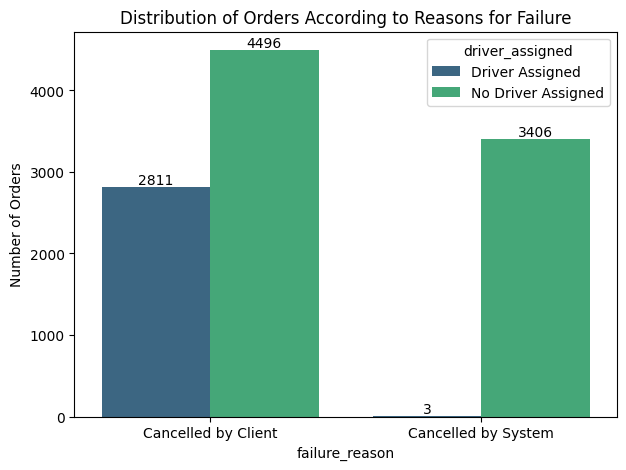

In [62]:
# Task 1: Distribution of Orders According to Reasons for Failure
orders['failure_reason'] = orders.apply(
    lambda x: 'Cancelled by Client' if x['order_status_key'] == 4 else 
              'Cancelled by System' if x['order_status_key'] == 9 else 'Other', axis=1)
orders['driver_assigned'] = orders['is_driver_assigned_key'].apply(lambda x: 'Driver Assigned' if x == 1 else 'No Driver Assigned')

# let's visualize the data using a countplot
plt.figure(figsize=(7,5))
ax1 = plt.subplot2grid((1,1),(0,0))
sns.countplot(x='failure_reason', data=orders, hue='driver_assigned', palette='viridis', ax=ax1)
for i in ax1.containers:
    plt.bar_label(i)
plt.title('Distribution of Orders According to Reasons for Failure')
plt.ylabel('Number of Orders')
plt.show()

#### # Task 2: Distribution of Failed Orders by Hours

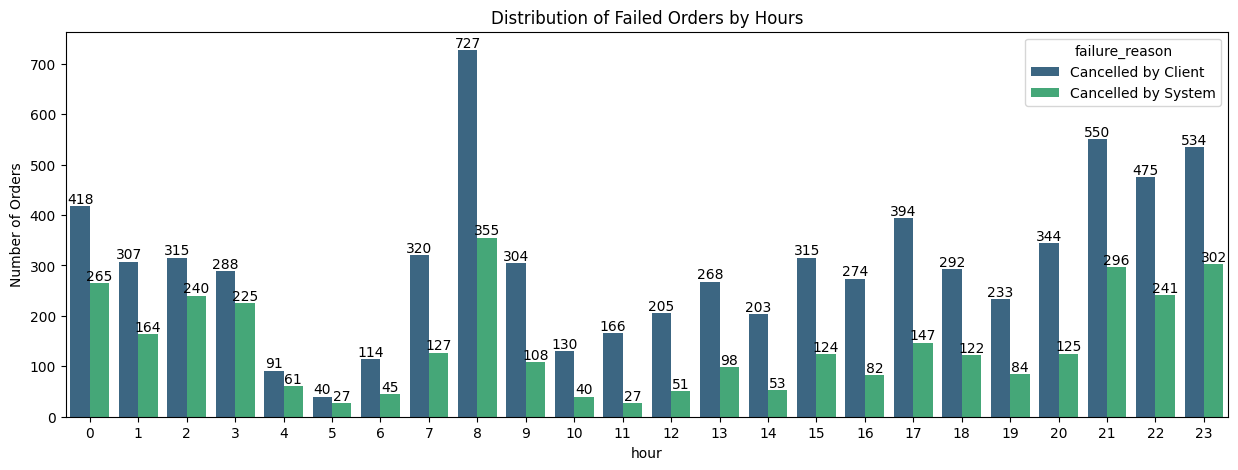

In [63]:
# Task 2: Distribution of Failed Orders by Hours
# let's visualize the data using a countplot
plt.figure(figsize=(15,5))
ax1 = plt.subplot2grid((1,1),(0,0))
sns.countplot(x='hour', data=orders, hue='failure_reason', palette='viridis', ax=ax1)
for i in ax1.containers:
    plt.bar_label(i)
plt.title('Distribution of Failed Orders by Hours')
plt.ylabel('Number of Orders')
plt.show()

#### # Task 3: Average Time to Cancellation by Hour

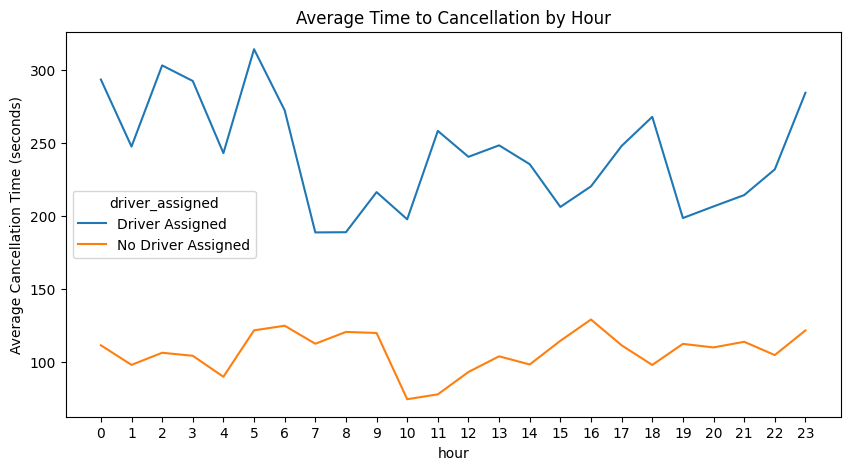

In [64]:
# Task 3: Average Time to Cancellation by Hour
plt.figure(figsize=(10,5))
sns.lineplot(x='hour', y='cancellations_time_in_seconds', hue='driver_assigned', data=orders, estimator='mean', ci=None)
plt.title('Average Time to Cancellation by Hour')
plt.ylabel('Average Cancellation Time (seconds)')
plt.xticks(np.arange(min(orders['hour']), max(orders['hour'])+1, 1.0))
plt.show()

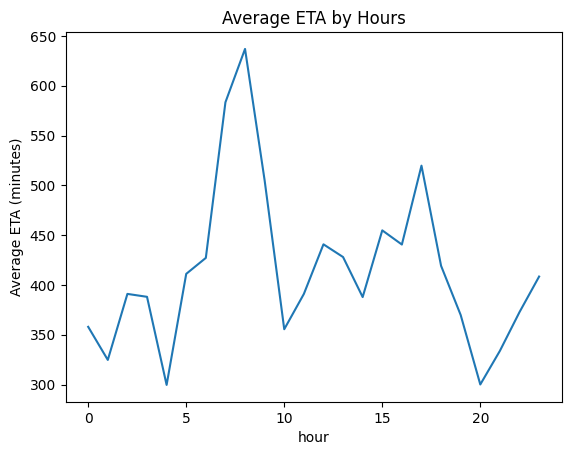

In [65]:
# Task 4: Distribution of Average ETA by Hours
avg_eta_by_hour = orders.groupby('hour')['m_order_eta'].mean()
avg_eta_by_hour.plot(kind='line')
plt.title('Average ETA by Hours')
plt.ylabel('Average ETA (minutes)')
plt.show()

In [66]:
# BONUS: Hexagons Visualization
def plot_hexagons(orders, resolution=8):
    hex_counts = {}
    for _, row in orders.iterrows():
        hex_id = h3.geo_to_h3(row['origin_latitude'], row['origin_longitude'], resolution)
        if hex_id not in hex_counts:
            hex_counts[hex_id] = 0
        hex_counts[hex_id] += 1
    
    hex_counts = dict(sorted(hex_counts.items(), key=lambda item: item[1], reverse=True))
    top_hexes = list(hex_counts.keys())[:int(0.8 * len(hex_counts))]
    
    map_center = [orders['origin_latitude'].mean(), orders['origin_longitude'].mean()]
    m = folium.Map(location=map_center, zoom_start=12)
    
    for hex_id in top_hexes:
        hex_boundary = h3.h3_to_geo_boundary(hex_id, geo_json=True)
        folium.Polygon(locations=hex_boundary, color='blue', fill=True, fill_opacity=0.6).add_to(m)
    
    return m

# Plot hexagons containing 80% of orders
m = plot_hexagons(orders)
m.save('hexagons_map.html')